# Neural Network Simulated Fabry–Pérot Interferometer

This study is a quick proof-of-concept to examine the viability of approximating a Fabry-Perot interferometer using a neural network. The ground truth is taken to be the Finesse 3 simulated data.

The optical configuration is:

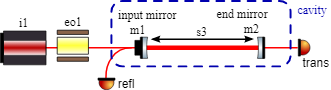

We allow the end mirror (m2) to vary in phi (along the optical axis) and s3 to vary in distance. The "target" was the measured output of the power detector, refl.

This code was ran on a Google Colab notebook (Intel Xeon CPU with 2 vCPUs), and runtime is specified accordingly.

# Imports

In [5]:
!pip install finesse
import numpy as np
import finesse
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Synthetic Dataset Generation

We use Finesse 3 to generate some training data. In particular, we sample 100 points for $s_3 \in [0,2, 1]$ and 400 points for $\phi \in [-100, 100]$ for a total of 40,000 data points. Run time is ~13 seconds.

In [3]:
finesse.configure(plotting=True)

lengths = np.linspace(0.2, 1, 100) # Samples 100 points from 0.2m to 1m
phi_lower_bound = -100
phi_upper_bound = 100
phi_num_samples = 400
phi_values = np.linspace(phi_lower_bound, phi_upper_bound, phi_num_samples)
data = []

# Iterates over lengths, creating a new model for each length.
for length in lengths:
    model = finesse.Model()

    # Creates the configuration shown above with the specified length
    model.parse(
        f"""
        laser i1 P=1 f=0
        space s1 portA=i1.p1 portB=eo1.p1
        modulator eo1 15M 0.7 order=3
        space s2 portA=eo1.p2 portB=m1.p1
        mirror m1 R=0.9 T=0.1
        space s3 portA=m1.p2 portB=m2.p1 L={length}
        mirror m2 R=0.9 T=0.1

        power_detector_dc refl node=m1.p1.o
        power_detector_dc trans node=m2.p2.o
        """
    )

    # Run the models for the range of phi values
    model.parse(f"xaxis(m2.phi, lin, {phi_lower_bound}, {phi_upper_bound}, {phi_num_samples})")
    results = model.run()

    reflection_results = results['refl'] # Grabs the data from the 'refl' power detector

    # Appends the data to the data list. Note: our data order is (length, phi, refl)
    for result, phi_value in zip(reflection_results, phi_values):
        data.append([length, phi_value, result])

In [4]:
np.shape(data)

(40000, 3)

# ANN Training

We train a ANN on our dataset. Our input layer has size 2 for length and phi, while our output layer is one neuron, to regress on the measured value of 'refl'. Training time is ~35 seconds.

In [10]:
# Convert 'data' to a numpy array
data = np.array(data)

X = data[:, :2]  # Input features length and phi, respectively
y = data[:, 2:]  # Target, 'refl'

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 4s 3ms/step - loss: 0.2261 - val_loss: 0.0088
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 3.4244e-04
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0122 - val_loss: 0.4329
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0126 - val_loss: 4.9746e-04
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0034 - val_loss: 2.5725e-04
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 2.4829e-04 - val_loss: 1.9845e-04
Epoch 8/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0026 - val_loss: 1.6175e-04
Epoch 9/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0039 - val_loss: 6.8127e-04
Epoch 10/10
1000/1000 [==============================]

# Comparisons with Ground Truth

In [11]:
def finesse_truth(length, phi):
    """
    Runs a Finesse 3 simulation to compute the power detector output.

    Parameters:
    - length (float): Length of s3
    - phi (float): Degrees of phi

    Returns:
    - float: Measured value at 'refl'
    """

    model = finesse.Model()
    model.parse(
        f"""
        laser i1 P=1 f=0
        space s1 portA=i1.p1 portB=eo1.p1
        modulator eo1 15M 0.7 order=3
        space s2 portA=eo1.p2 portB=m1.p1
        mirror m1 R=0.9 T=0.1
        space s3 portA=m1.p2 portB=m2.p1 L={length}
        mirror m2 R=0.9 T=0.1

        power_detector_dc refl node=m1.p1.o
        power_detector_dc trans node=m2.p2.o
        """
    )

    model.m2.phi = phi
    results = model.run()
    return results['refl']

## We examine some 2D graphs by fixing $\phi = 0$

4/4 [==============================] - 0s 3ms/step


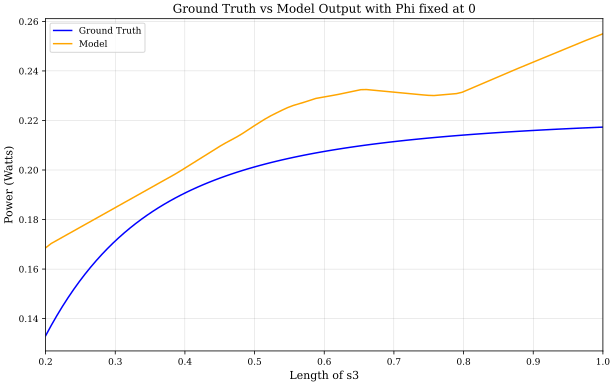

In [13]:
# Define input range for length
length_range = np.linspace(0.2, 1, 100)

# Fix phi at 0
phi_range = np.zeros_like(length_range)

# Generate inputs for plotting
inputs = np.column_stack((length_range, phi_range))

# Calculate the outputs of the ground truth and the model
ground_truth = np.array([finesse_truth(x[0], x[1]) for x in inputs])
model_outputs = model.predict(inputs).flatten()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(length_range, ground_truth, label='Ground Truth', color='blue')
plt.plot(length_range, model_outputs, label='Model', color='orange')

# Set labels and title
plt.xlabel('Length of s3')
plt.ylabel('Power (Watts)')
plt.title('Ground Truth vs Model Output with Phi fixed at 0')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


## We make another 2D graph fixing $s_3 = 1$

7/7 [==============================] - 0s 2ms/step


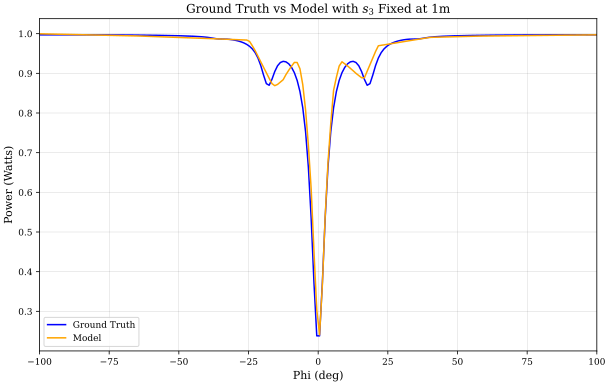

In [14]:
# Fix s_3 at 1
length_range = np.ones(200)

# Let phi vary from -100 to 100 deg
phi_range = np.linspace(-100, 100, 200)

# Generate inputs
inputs = np.column_stack((length_range, phi_range))

# Calculate the outputs of the ground truth and the model
ground_truth = np.array([finesse_truth(x[0], x[1]) for x in inputs])
model_outputs = model.predict(inputs).flatten()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(phi_range, ground_truth, label='Ground Truth', color='blue')
plt.plot(phi_range, model_outputs, label='Model', color='orange')

# Set labels and title
plt.xlabel('Phi (deg)')
plt.ylabel('Power (Watts)')
plt.title('Ground Truth vs Model with $s_3$ Fixed at 1m')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


## Relative Error Plots

We sample 400 data points to test the relative errors

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Define input ranges
length_range = np.linspace(0.2, 1, 20)
phi_range = np.linspace(-100, 100, 20)

# Generate inputs for plotting
length_range, phi_range = np.meshgrid(length_range, phi_range)

# Calculate the outputs of the ground truth and the model
ground_truth = np.array([finesse_truth(x[0], x[1]) for x in zip(length_range.flatten(), phi_range.flatten())]).reshape(length_range.shape)
model_outputs = model.predict(np.column_stack((length_range.flatten(), phi_range.flatten()))).reshape(length_range.shape)

# Calculate absolute difference
absolute_difference = np.abs(ground_truth - model_outputs)

13/13 [==============================] - 0s 3ms/step


In [16]:
relative_error = np.abs(ground_truth - model_outputs) / np.abs(ground_truth)

<ipython-input-23-7cd57912a3c8>:13: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13 # Zooms out a little


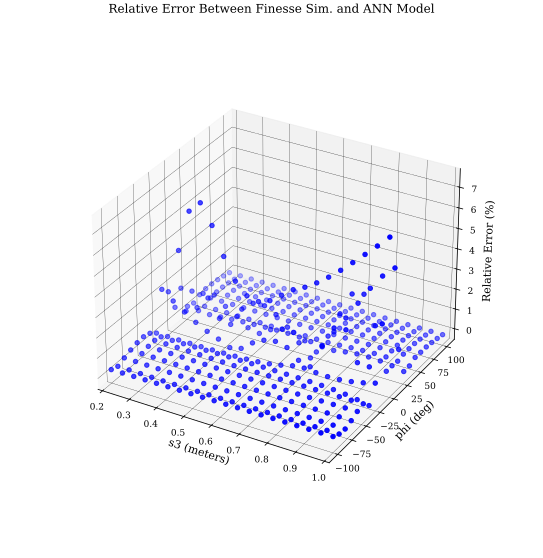

In [23]:
# Relative Error Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot relative error as scatter
scatter = ax.scatter(length_range.flatten(), phi_range.flatten(), relative_error.flatten()*100)

# Set labels and title
ax.set_xlabel('s3 (meters)')
ax.set_ylabel('phi (deg)')
ax.set_zlabel('Relative Error (%)')
ax.set_title('Relative Error Between Finesse Sim. and ANN Model')
ax.dist = 13 # Zooms out a little

plt.tight_layout()

#plt.savefig('plot.png')

plt.show()


<ipython-input-21-f24c527e12af>:13: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13 # Zooms out a little


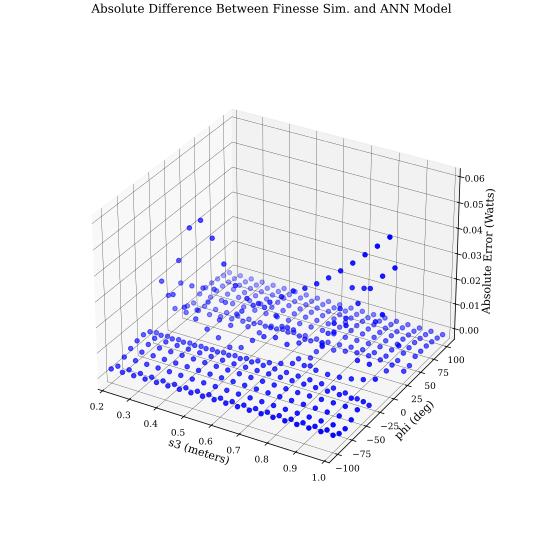

In [21]:
# Absolute Error Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot relative error as scatter
scatter = ax.scatter(length_range.flatten(), phi_range.flatten(), absolute_difference.flatten())

# Set labels and title
ax.set_xlabel('s3 (meters)')
ax.set_ylabel('phi (deg)')
ax.set_zlabel('Absolute Error (Watts)')
ax.set_title('Absolute Difference Between Finesse Sim. and ANN Model')
ax.dist = 13 # Zooms out a little

plt.tight_layout()

#plt.savefig('plot.png')

plt.show()

# Runtime Comparisons

In [41]:
# Define some test inputs
phi_range = np.linspace(-100, 100, 100)

In [47]:
import timeit

# Timing Finesse 3
start = timeit.default_timer()
for phi in phi_range:
    finesse_truth(1, phi)
stop = timeit.default_timer()

finesse_time = stop-start

# Timing Model
start = timeit.default_timer()
for phi in phi_range:
    model.predict([[1, phi]], verbose=0)
stop = timeit.default_timer()

model_time = stop-start

print(f'Time for ANN to evaluate 100 points:{model_time} seconds')
print(f'Time for Finesse 3 to evaluate 100 points:{finesse_time} seconds')

Time for ANN to evaluate 100 points:10.479656660000273 seconds
Time for Finesse 3 to evaluate 100 points:6.463235327999882 seconds
